# **Library Installation and Imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import math

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from xgboost import XGBRegressor

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


# **Load Processed DataFrames**

In [ ]:
load_path = "/content/drive/MyDrive/DS_LAB/Processed/pkl/"

filtered_user1 = pd.read_pickle(load_path + "filtered_user1.pkl")
filtered_user2 = pd.read_pickle(load_path + "filtered_user2.pkl")
combined_df   = pd.read_pickle(load_path + "combined_df.pkl")

print("DataFrames loaded")
print(f"User1 shape: {filtered_user1.shape}")
print(f"User2 shape: {filtered_user2.shape}")
print(f"Combined shape: {combined_df.shape}")

DataFrames loaded
User1 shape: (645, 15)
User2 shape: (645, 15)
Combined shape: (1290, 15)


# **Feature Engineering**

In [ ]:
def ensure_sorted(df: pd.DataFrame, user_col: str | None = None) -> pd.DataFrame:
    df = df.copy()
    if not np.issubdtype(df['datetime'].dtype, np.datetime64):
        df['datetime'] = pd.to_datetime(df['datetime'])
    if user_col and user_col in df.columns:
        return df.sort_values([user_col, 'datetime']).reset_index(drop=True)
    return df.sort_values('datetime').reset_index(drop=True)

filtered_user1 = ensure_sorted(filtered_user1, user_col=None)
filtered_user1.head(3)

,user_id,datetime,time_of_day,wpm,rawWpm,acc,consistency,restartCount,testDuration,afkDuration,incompleteTestSeconds,correct_characters,incorrect_characters,extra_characters,missed_characters
0,1,2024-11-10 08:36:37,morning,69.56,71.56,95.68,73.83,0,30.02,0,0.0,174,1,0,0
1,1,2024-11-10 08:37:10,morning,56.80,58.80,95.42,63.73,0,30.00,0,0.0,142,1,0,0
2,1,2024-11-10 08:37:48,morning,62.80,70.80,91.06,76.91,0,30.00,0,0.0,157,10,0,3


In [ ]:
def engineer_next_wpm(
    df: pd.DataFrame,
    *,
    target_col: str = "wpm",
    include_time_of_day: bool = True,
    lag_steps: tuple[int, ...] = (1, 2),
    roll_windows: tuple[int, ...] = (3, 5),):

    df = df.copy()

    if include_time_of_day and "time_of_day" in df.columns:
        df = pd.get_dummies(df, columns=["time_of_day"], drop_first=True)

    df["y_next"] = df[target_col].shift(-1)


    cur_feats = ["wpm", "acc", "consistency"]

    for k in lag_steps:
        df[f"wpm_lag{k}"] = df["wpm"].shift(k)
        df[f"acc_lag{k}"] = df["acc"].shift(k)
        df[f"consistency_lag{k}"] = df["consistency"].shift(k)

    for w in roll_windows:
        df[f"wpm_roll{w}_mean"] = df["wpm"].rolling(w, min_periods=1).mean()
        df[f"wpm_roll{w}_std"]  = df["wpm"].rolling(w, min_periods=2).std()
        df[f"acc_roll{w}_mean"] = df["acc"].rolling(w, min_periods=1).mean()
        df[f"acc_roll{w}_std"]  = df["acc"].rolling(w, min_periods=2).std()

    for span in (3, 5, 10):
        df[f"wpm_ewm{span}"] = df["wpm"].ewm(span=span, min_periods=1, adjust=False).mean()
        df[f"acc_ewm{span}"] = df["acc"].ewm(span=span, min_periods=1, adjust=False).mean()

    df["wpm_cummean"] = df["wpm"].expanding(min_periods=1).mean()
    df["wpm_cumstd"]  = df["wpm"].expanding(min_periods=2).std()
    df["acc_cummean"] = df["acc"].expanding(min_periods=1).mean()

    df["wpm_diff1"] = df["wpm"] - df["wpm"].shift(1)
    df["acc_diff1"] = df["acc"] - df["acc"].shift(1)
    df["wpm_pct_change1"] = df["wpm"].pct_change().replace([np.inf, -np.inf], np.nan)

    for w in roll_windows:
        mean_col = f"wpm_roll{w}_mean"
        dev_col  = f"wpm_minus_roll{w}"
        df[dev_col] = df["wpm"] - df[mean_col]

    def _slope(arr):

        if arr.size < 2:
            return np.nan
        x = np.arange(arr.size)
        try:
            return np.polyfit(x, arr, 1)[0]
        except Exception:
            return 0.0

    df["wpm_slope3"] = df["wpm"].rolling(3, min_periods=2).apply(_slope, raw=True)
    df["wpm_slope5"] = df["wpm"].rolling(5, min_periods=2).apply(_slope, raw=True)


    # df["session_idx"] = np.arange(len(df))

    base_cols = [
        "restartCount","testDuration","afkDuration","incompleteTestSeconds",
        "correct_characters","incorrect_characters","extra_characters","missed_characters",
    ]

    base_feats = [c for c in base_cols if c in df.columns]
    tod_feats  = [c for c in df.columns if c.startswith("time_of_day_")]
    lag_feats  = [f for f in df.columns if f.endswith(tuple(f"_lag{k}" for k in lag_steps))]
    roll_feats = [c for c in df.columns if any(c.startswith(p) for p in ("wpm_roll","acc_roll"))]

    new_prefixes = (
        "wpm_ewm", "acc_ewm",
        "wpm_cum", "acc_cum",
        "wpm_diff", "acc_diff",
        "wpm_pct_change",
        "wpm_minus_roll",
        "wpm_slope",
    )
    new_feats = [c for c in df.columns if c.startswith(new_prefixes)]

    # if "session_idx" in df.columns:
    #     new_feats.append("session_idx")

    std_cols = [c for c in df.columns if c.endswith("_std")]
    for c in std_cols:
        df[c].fillna(0, inplace=True)

    feature_cols = (
        cur_feats
        + lag_feats
        + roll_feats
        + new_feats
        + base_feats
        + tod_feats
    )

    required = ["y_next"] + [f"wpm_lag{k}" for k in lag_steps]
    sup = df.dropna(subset=required).copy()
    X = sup[feature_cols].astype(float)
    X = X.fillna(X.median()).fillna(0)

    y = sup["y_next"].astype(float)
    meta = sup[["datetime"]].copy()

    return sup, X, y, feature_cols, meta

supervised_u1, X_u1, y_u1, feat_cols_u1, meta_u1 = engineer_next_wpm(filtered_user1)
print("X shape:", X_u1.shape)
print("Y shape:", y_u1.shape)
print("Any NaNs in X?", X_u1.isna().any().any())
print("NaN counts (by column) in X (if any):")
print(X_u1.isna().sum()[X_u1.isna().sum() > 0])
print("Feature sample:", feat_cols_u1[:20])
print()
X_u1.head(3)

X shape: (642, 44)
Y shape: (642,)
Any NaNs in X? False
NaN counts (by column) in X (if any):
Series([], dtype: int64)
Feature sample: ['wpm', 'acc', 'consistency', 'wpm_lag1', 'acc_lag1', 'consistency_lag1', 'wpm_lag2', 'acc_lag2', 'consistency_lag2', 'wpm_roll3_mean', 'wpm_roll3_std', 'acc_roll3_mean', 'acc_roll3_std', 'wpm_roll5_mean', 'wpm_roll5_std', 'acc_roll5_mean', 'acc_roll5_std', 'wpm_ewm3', 'acc_ewm3', 'wpm_ewm5']



/tmp/ipython-input-1057435510.py:88: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(0, inplace=True)


,wpm,acc,consistency,wpm_lag1,acc_lag1,consistency_lag1,wpm_lag2,acc_lag2,consistency_lag2,wpm_roll3_mean,...,testDuration,afkDuration,incompleteTestSeconds,correct_characters,incorrect_characters,extra_characters,missed_characters,time_of_day_evening,time_of_day_morning,time_of_day_night
2,62.80,91.06,76.91,56.80,95.42,63.73,69.56,95.68,73.83,63.053333,...,30.00,0.0,0.00,157.0,10.0,0.0,3.0,0.0,1.0,0.0
3,66.79,94.05,74.85,62.80,91.06,76.91,56.80,95.42,63.73,62.130000,...,30.00,0.0,0.00,167.0,4.0,0.0,0.0,0.0,1.0,0.0
4,75.16,96.48,76.81,66.79,94.05,74.85,62.80,91.06,76.91,68.250000,...,30.01,0.0,5.14,188.0,3.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Leakage Audit
audit_cols = ["datetime","wpm","y_next","wpm_lag1","wpm_lag2","wpm_roll3_mean"]
print(supervised_u1[audit_cols].head(12))

              datetime    wpm  y_next  wpm_lag1  wpm_lag2  wpm_roll3_mean
2  2024-11-10 08:37:48  62.80   66.79     56.80     69.56       63.053333
3  2024-11-10 08:38:22  66.79   75.16     62.80     56.80       62.130000
4  2024-11-11 09:00:17  75.16   65.99     66.79     62.80       68.250000
5  2024-11-11 11:44:06  65.99   73.19     75.16     66.79       69.313333
6  2024-11-11 11:44:39  73.19   73.20     65.99     75.16       71.446667
7  2024-11-11 11:46:20  73.20   65.97     73.19     65.99       70.793333
8  2024-11-11 11:46:54  65.97   71.18     73.20     73.19       70.786667
9  2024-11-11 11:47:27  71.18   67.99     65.97     73.20       70.116667
10 2024-11-11 11:48:02  67.99   64.40     71.18     65.97       68.380000
11 2024-11-11 11:48:39  64.40   64.39     67.99     71.18       67.856667
12 2024-11-11 11:49:13  64.39   62.40     64.40     67.99       65.593333
13 2024-11-11 11:49:48  62.40   62.79     64.39     64.40       63.730000


In [ ]:
def time_split_single(X, y, meta, train=0.7, val=0.15, test=0.15):
    n = len(meta)
    i1 = int(n * train)
    i2 = int(n * (train + val))

    X_tr, y_tr = X.iloc[:i1], y.iloc[:i1]
    X_va, y_va = X.iloc[i1:i2], y.iloc[i1:i2]
    X_te, y_te = X.iloc[i2:],  y.iloc[i2:]

    return X_tr, y_tr, X_va, y_va, X_te, y_te

X_tr, y_tr, X_va, y_va, X_te, y_te = time_split_single(X_u1, y_u1, meta_u1)

print("Train size:", X_tr.shape, y_tr.shape)
print("Val size:", X_va.shape, y_va.shape)
print("Test size:", X_te.shape, y_te.shape)

Train size: (449, 44) (449,)
Val size: (96, 44) (96,)
Test size: (97, 44) (97,)


In [ ]:
def eval_regression(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} -> MAE: {mae:.3f} | RMSE: {rmse:.3f}")

baseline_last = X_te["wpm"]
baseline_roll3 = X_te["wpm_roll3_mean"].fillna(baseline_last)

eval_regression("Baseline (next = current WPM)", y_te, baseline_last)
eval_regression("Baseline (next = rolling-3 WPM)", y_te, baseline_roll3)

Baseline (next = current WPM) -> MAE: 6.485 | RMSE: 8.279
Baseline (next = rolling-3 WPM) -> MAE: 5.123 | RMSE: 6.605


# **Supervised Learning - RFR**

In [ ]:
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_split=4,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_tr, y_tr)

def report_model(name, model, Xv, yv, Xt, yt):
    yv_pred = model.predict(Xv)
    yt_pred = model.predict(Xt)
    tol = 3.0
    mae_v = mean_absolute_error(yv, yv_pred)
    rmse_v = math.sqrt(mean_squared_error(yv, yv_pred))
    mae_t = mean_absolute_error(yt, yt_pred)
    rmse_t = math.sqrt(mean_squared_error(yt, yt_pred))
    acc_v = float((np.abs(yv - yv_pred) <= tol).mean())
    acc_t = float((np.abs(yt - yt_pred) <= tol).mean())

    print(f"{name}")
    print(f"Validation -> MAE: {mae_v:.3f} | RMSE: {rmse_v:.3f} | Acc(@{tol}WPM): {acc_v:.3%}")
    print(f"Test       -> MAE: {mae_t:.3f} | RMSE: {rmse_t:.3f} | Acc(@{tol}WPM): {acc_t:.3%}")


report_model("Random Forest (next-WPM)", rf, X_va, y_va, X_te, y_te)

Random Forest (next-WPM)
Validation -> MAE: 3.806 | RMSE: 4.659 | Acc(@3.0WPM): 48.958%
Test       -> MAE: 4.961 | RMSE: 6.266 | Acc(@3.0WPM): 30.928%


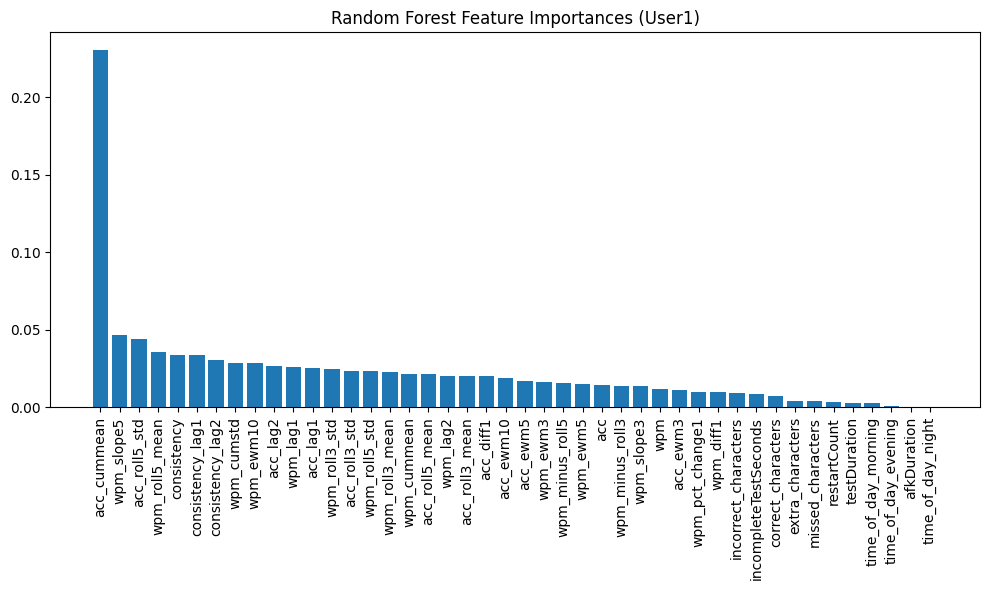

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feat_cols_u1[i] for i in indices], rotation=90)
plt.title("Random Forest Feature Importances (User1)")
plt.tight_layout()
plt.show()

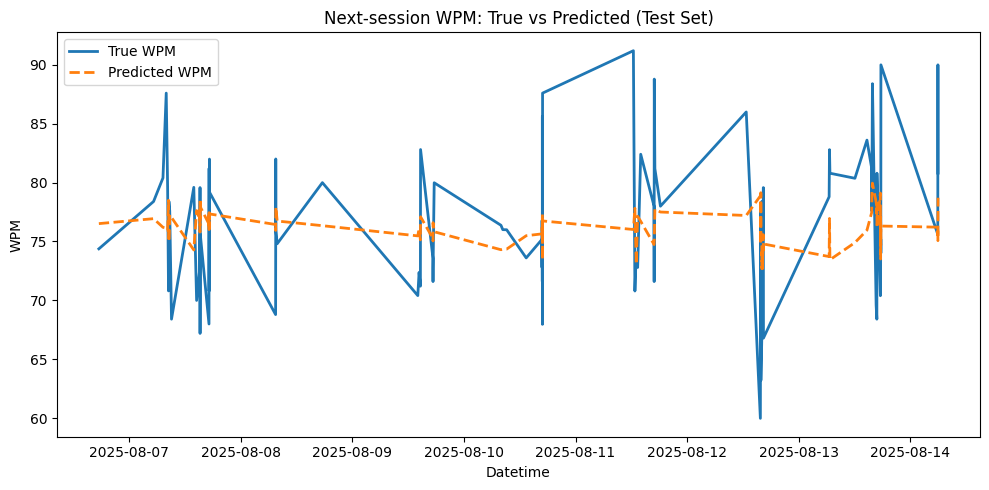

In [ ]:
y_pred_te = rf.predict(X_te)

plt.figure(figsize=(10,5))
plt.plot(meta_u1.iloc[len(X_tr)+len(X_va):]['datetime'], y_te.values, label="True WPM", linewidth=2)
plt.plot(meta_u1.iloc[len(X_tr)+len(X_va):]['datetime'], y_pred_te, label="Predicted WPM", linewidth=2, linestyle="--")
plt.xlabel("Datetime")
plt.ylabel("WPM")
plt.title("Next-session WPM: True vs Predicted (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()

# **Supervised Learning - LightGBM**

In [ ]:
lgb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.03,
    "num_leaves": 127,
    "min_child_samples": 5,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 5,
    "max_depth": -1,
    "random_state": 42,
    "n_jobs": -1,
}

model_lgb = LGBMRegressor(**lgb_params)
model_lgb.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    eval_metric="l1",
    callbacks=[early_stopping(50), log_evaluation(50)]
)

y_va_pred = model_lgb.predict(X_va, num_iteration=model_lgb.best_iteration_)
y_te_pred = model_lgb.predict(X_te, num_iteration=model_lgb.best_iteration_)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4968
[LightGBM] [Info] Number of data points in the train set: 449, number of used features: 44
[LightGBM] [War

In [ ]:
def regression_metrics(y_true, y_pred, tol=3.0):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    acc = float((np.abs(y_true - y_pred) <= tol).mean())
    return mae, rmse, acc

tol = 3.0
va_mae, va_rmse, va_acc = regression_metrics(y_va, y_va_pred, tol=tol)
te_mae, te_rmse, te_acc = regression_metrics(y_te, y_te_pred, tol=tol)

print("LightGBM (next-WPM)")
print(f"Validation -> MAE: {va_mae:.3f} | RMSE: {va_rmse:.3f} | Acc(@{tol}WPM): {va_acc:.3%}")
print(f"Test       -> MAE: {te_mae:.3f} | RMSE: {te_rmse:.3f} | Acc(@{tol}WPM): {te_acc:.3%}")

LightGBM (next-WPM)
Validation -> MAE: 3.851 | RMSE: 4.810 | Acc(@3.0WPM): 42.708%
Test       -> MAE: 5.047 | RMSE: 6.535 | Acc(@3.0WPM): 41.237%


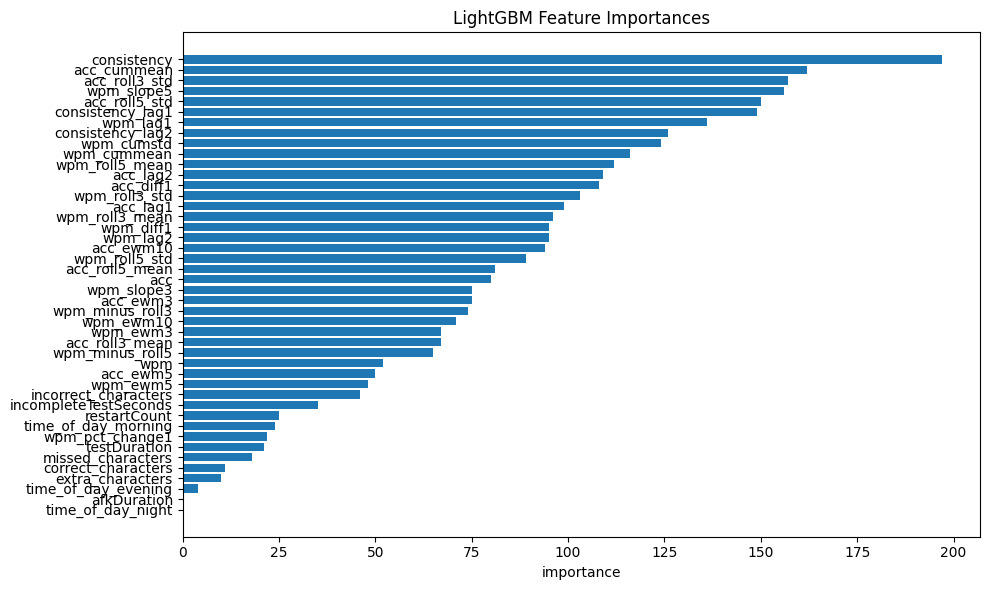

In [ ]:
importances = model_lgb.feature_importances_
feat_names = X_tr.columns.to_list()
imp_df = (pd.DataFrame({"feature": feat_names, "importance": importances})
            .sort_values("importance", ascending=False))

plt.figure(figsize=(10,6))
plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
plt.title("LightGBM Feature Importances")
plt.xlabel("importance")
plt.tight_layout()
plt.show()

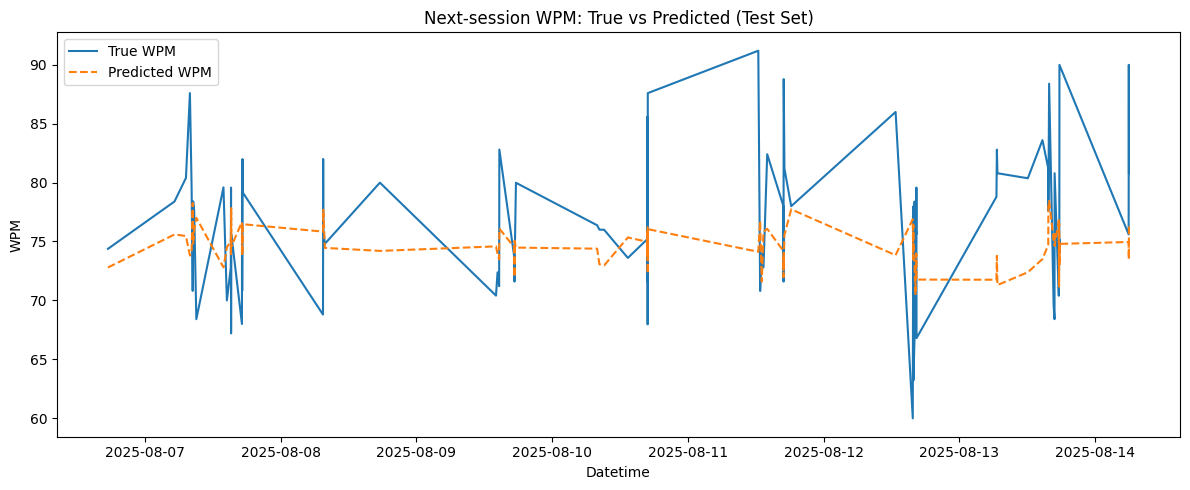

In [ ]:
n = len(meta_u1)
i1 = int(n * 0.7)
i2 = int(n * 0.85)
meta_te = meta_u1.iloc[i2:]

plt.figure(figsize=(12,5))
plt.plot(meta_te["datetime"], y_te, label="True WPM")
plt.plot(meta_te["datetime"], y_te_pred, "--", label="Predicted WPM")
plt.title("Next-session WPM: True vs Predicted (Test Set)")
plt.xlabel("Datetime")
plt.ylabel("WPM")
plt.legend()
plt.tight_layout()
plt.show()

# **Supervised Learning - XGBoost**

In [ ]:
xgb_params = {
    "n_estimators": 500,
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "gamma": 0.0,
    "min_child_weight": 1,
    "random_state": 42,
    "n_jobs": -1,
}

model_xgb = XGBRegressor(**xgb_params)
model_xgb.fit(X_tr, y_tr)

y_va_pred = model_xgb.predict(X_va)
y_te_pred = model_xgb.predict(X_te)

In [ ]:
def regression_metrics(y_true, y_pred, tol=3.0):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    acc = float((np.abs(y_true - y_pred) <= tol).mean())
    return mae, rmse, acc

tol = 3.0
va_mae, va_rmse, va_acc = regression_metrics(y_va, y_va_pred, tol=tol)
te_mae, te_rmse, te_acc = regression_metrics(y_te, y_te_pred, tol=tol)

print("XGBoost (next-WPM)")
print(f"Validation -> MAE: {va_mae:.3f} | RMSE: {va_rmse:.3f} | Acc(@{tol}WPM): {va_acc:.3%}")
print(f"Test       -> MAE: {te_mae:.3f} | RMSE: {te_rmse:.3f} | Acc(@{tol}WPM): {te_acc:.3%}")

XGBoost (next-WPM)
Validation -> MAE: 4.115 | RMSE: 5.222 | Acc(@3.0WPM): 45.833%
Test       -> MAE: 5.315 | RMSE: 6.864 | Acc(@3.0WPM): 39.175%


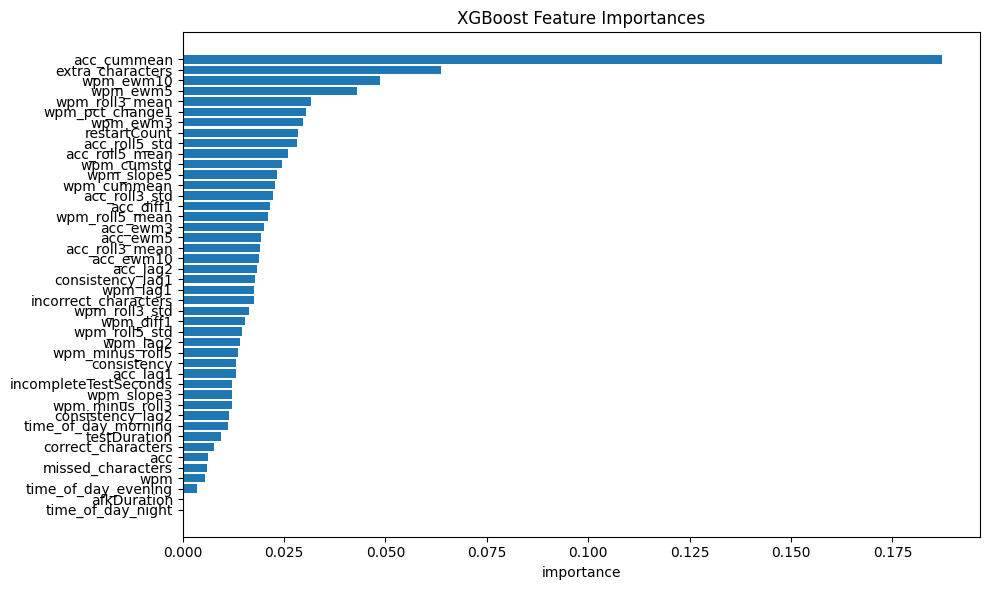

In [ ]:
imp_vals = model_xgb.feature_importances_
feat_names = X_tr.columns.to_list()
imp_df = pd.DataFrame({"feature": feat_names, "importance": imp_vals}).sort_values("importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
plt.title("XGBoost Feature Importances")
plt.xlabel("importance")
plt.tight_layout()
plt.show()

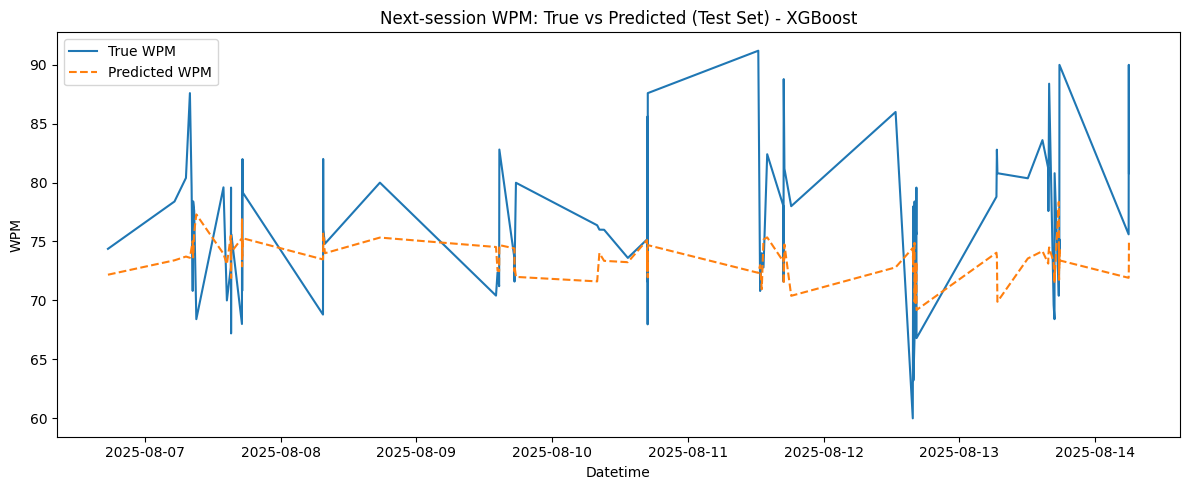

In [ ]:
n = len(meta_u1)
i1 = int(n * 0.7)
i2 = int(n * 0.85)
meta_te = meta_u1.iloc[i2:].reset_index(drop=True)

plt.figure(figsize=(12,5))
plt.plot(meta_te["datetime"], y_te.reset_index(drop=True), label="True WPM")
plt.plot(meta_te["datetime"], pd.Series(y_te_pred).reset_index(drop=True), "--", label="Predicted WPM")
plt.title("Next-session WPM: True vs Predicted (Test Set) - XGBoost")
plt.xlabel("Datetime")
plt.ylabel("WPM")
plt.legend()
plt.tight_layout()
plt.show()